In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf
import glob
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from tqdm import tqdm_notebook
from multiprocessing import Pool
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(42)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)
BUFFER_SIZE= 100

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pywsi.io.operations import get_annotation_bounding_boxes
from pywsi.io.operations import get_annotation_polygons
from pywsi.io.operations import path_leaf
from pywsi.io.operations import read_as_rgb
from pywsi.io.operations import WSIReader
from pywsi.io.tiling import get_all_patches_from_slide
from pywsi.io.tiling import save_images_and_mask, generate_tiles, generate_tiles_fast

from pywsi.morphology.patch_extractor import TissuePatch
from pywsi.morphology.mask import get_common_interior_polygons
from tqdm import tqdm
from multiprocessing import Pool
from pywsi.segmentation import label_nuclei, summarize_region_properties
from pywsi.deep_model.model import slide_level_map

from collections import defaultdict
import joblib
import numpy as np
from six import iteritems
import pandas as pd

Using TensorFlow backend.


In [ ]:
train_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented.tsv')

is_tumor_idx = list(train_samples.columns).index('is_tumor')

In [ ]:
def order(frame,var):
    if type(var) is str:
        var = [var] #let the command take a string or list
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

In [ ]:
# Parameters
num_steps = 500 # Total steps to train
batch_size = 1#024 # The number of samples per batch
num_classes = 2 # 2 classes
num_features = 46 # columns in the feature
num_trees = 100
max_nodes = 10000

def _parse_csv(rows_string_tensor):
        """Takes the string input tensor and returns tuple of (features, labels)."""
        # Last dim is the label.        
        num_columns = num_features + 1 
        columns = tf.decode_csv(rows_string_tensor,
                                record_defaults=[[0.0]] * num_columns , 
                                field_delim='\t')
        label = columns[0]
        print(label)
        #label = columns[is_tumor_idx]
        #stack1 = tf.stack(columns[0: is_tumor_idx])
        #stack2 = tf.stack(columns[is_tumor_idx+1:])
        #return tf.stack([columns[x0: is_tumor_idx], columns[is_tumor_idx+1:]]), tf.cast(label, tf.int32)
        return tf.cast(tf.stack(columns[1:]), tf.float32), tf.cast(label, tf.int32)
        #return  tf.cast(label, tf.int32),  tf.cast(label, tf.int32)

def input_fn(file_names, batch_size):   

    """The input_fn."""
    dataset = tf.data.TextLineDataset(file_names).skip(1)
    # Skip the first line (which does not have data).
    dataset = dataset.map(_parse_csv)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

    dataset = dataset.batch(batch_size)
    iterator = tf.data.Iterator.from_structure(dataset.output_types,
                                               dataset.output_shapes)
    next_batch = iterator.get_next()
    init_op = iterator.make_initializer(dataset)
    return init_op, next_batch



In [ ]:
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
                     resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

In [ ]:
train_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented.tsv')
train_samples = train_samples.drop(columns='0')

validation_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_with_mask_segmented.tsv')
validation_samples = validation_samples.drop(columns='0')


train_samples_labels = pd.read_table(
    '/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_with_mask.tsv'
)
validation_samples_labels = pd.read_table(
    '/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_with_mask.tsv'
)
train_samples = order(train_samples, ['is_tumor'])
train_samples.is_tumor = train_samples.is_tumor.astype('int32')

validation_samples_labels.is_tumor = validation_samples_labels.is_tumor.astype('int32')
train_samples_labels.is_tumor = train_samples_labels.is_tumor.astype('int32')


train_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels.tsv',
                    index=False,
                    header=True,
                    sep='\t')


validation_samples = order(validation_samples, ['is_tumor'])
validation_samples.is_tumor = validation_samples.is_tumor.astype('int32')
validation_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels.tsv',
                    index=False,
                    header=True,
                    sep='\t')

validation_samples_labels_tumor = validation_samples_labels[validation_samples_labels.is_tumor==1].sample(frac=0.45, random_state=42)
validation_samples_labels_normal = validation_samples_labels[validation_samples_labels.is_tumor==0].sample(frac=0.45, random_state=43)

train_samples_labels_tumor = train_samples_labels[train_samples_labels.is_tumor==1].sample(frac=0.45, random_state=42)
train_samples_labels_normal = train_samples_labels[train_samples_labels.is_tumor==0].sample(frac=0.45, random_state=43)


validation_samples_labels = pd.concat([validation_samples_labels_tumor, validation_samples_labels_normal]).sample(frac=1, random_state=43)
train_samples_labels = pd.concat([train_samples_labels_tumor, train_samples_labels_normal]).sample(frac=1, random_state=43)

#validation_samples['img_path'] = ''
#validation_samples['mask_path'] = ''



# Sample only half the points
train_samples_tumor = train_samples[train_samples.is_tumor==True].sample(frac=0.45, random_state=42)
train_samples_normal = train_samples[train_samples.is_tumor==False].sample(frac=0.45, random_state=43)

validation_samples_tumor = validation_samples[validation_samples.is_tumor==True].sample(frac=0.45, random_state=42)
validation_samples_normal = validation_samples[validation_samples.is_tumor==False].sample(frac=0.45, random_state=43)


train_samples = pd.concat([train_samples_tumor, train_samples_normal]).sample(frac=1, random_state=42)
train_samples['img_path'] = train_samples_labels.img_path.tolist()
train_samples['is_tissue'] = train_samples_labels.is_tissue.tolist()
train_samples['uid'] = train_samples_labels.uid.tolist()
train_samples['mask_path'] = train_samples_labels.mask_path.tolist()
train_samples.loc[train_samples.img_path!=train_samples.img_path, 'img_path'] = 'xxx'
train_samples.loc[train_samples.mask_path!=train_samples.mask_path, 'mask_path'] = 'yyy'
train_samples = train_samples.dropna()
train_samples = train_samples.reset_index(drop=True)

validation_samples = pd.concat([validation_samples_tumor, validation_samples_normal]).sample(frac=1, random_state=43)
validation_samples['img_path'] = validation_samples_labels.img_path.tolist()
validation_samples['is_tissue'] = validation_samples_labels.is_tissue.tolist()
validation_samples['uid'] = validation_samples_labels.uid.tolist()
validation_samples['mask_path'] = validation_samples_labels.mask_path.tolist()
validation_samples.loc[validation_samples.img_path!=validation_samples.img_path, 'img_path'] = 'xxx'
validation_samples.loc[validation_samples.mask_path!=validation_samples.mask_path, 'mask_path'] = 'yyy'
validation_samples = validation_samples.dropna()
validation_samples = validation_samples.reset_index(drop=True)

train_samples = train_samples.dropna()
validation_samples = validation_samples.dropna()


train_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels_subsampled_v1.tsv',
                    index=False,
                    header=True,
                    sep='\t')


validation_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels_subsampled_v1.tsv',
                    index=False,
                    header=True,
                    sep='\t')

train_samples.head()

In [ ]:
len(train_samples_labels.index)


In [ ]:
train_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented.tsv')

len(train_samples.index)

In [ ]:
print(train_samples.columns)

In [ ]:
len(validation_samples.index)

In [ ]:
training_init_op, training_next_batch =  input_fn(['/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels_subsampled.tsv'],
                                                  1024)



In [ ]:
for epoch in range(num_steps):
    sess.run(training_init_op)    
    while True:
        try:
            training_features_batch, training_label_batch = sess.run(training_next_batch)
        except tf.errors.OutOfRangeError:
            break
        _, l = sess.run([train_op, loss_op], 
                        feed_dict={X: training_features_batch,
                                   Y: training_label_batch})
    acc = sess.run(accuracy_op, 
                   feed_dict={X: training_features_batch, 
                              Y: training_label_batch})
    print('Step %i, Loss: %f, Acc: %f' % (epoch, l, acc))

In [ ]:
validation_df = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels_subsampled_v1.tsv').copy()
validation_df = order(validation_df, ['is_tumor', 'is_tissue', 'uid', 'img_path', 'mask_path'])
validation_df['pred_probability'] = None
validation_df['pred_label'] = None

for idx, row in validation_df.iterrows():    
    validation_label_batch = row.values[0]
    validation_features_batch = row.values[5:-2]    
    prob = sess.run(infer_op, 
                     feed_dict={X: [validation_features_batch]})[0][1]
    validation_df.loc[idx, 'pred_probability'] = prob
    if prob>0.5:
        validation_df.loc[idx, 'pred_label'] = 1
    else:
        validation_df.loc[idx, 'pred_label'] = 0
    

In [ ]:
validation_df.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels_subsampled_v1_predicted.tsv',
                    sep='\t',
                    index=False,
                    header=True)

In [ ]:
#len(validation_acc)
plt.hist(validation_acc)

In [ ]:
validation_prob = []
validation_labels = []
sess.run(validation_init_op)    
while True:
    try:
        validation_features_batch,  validation_label_batch = sess.run(validation_next_batch)
        validation_labels.append(validation_label_batch[0])
    except tf.errors.OutOfRangeError:
        break
    acc = sess.run(infer_op, 
                   feed_dict={X: validation_features_batch})
    validation_prob.append(acc[0][1])

In [ ]:
joblib.dump(validation_prob, '/Z/personal-folders/interns/saket/github/pywsi/pickles/random_forest_valid_prob.joblib.pickle')
joblib.dump(validation_labels, '/Z/personal-folders/interns/saket/github/pywsi/pickles/random_forest_valid_true.joblib.pickle')
joblib.dump(validation_acc, '/Z/personal-folders/interns/saket/github/pywsi/pickles/random_forest_valid_acc.joblib.pickle')


In [ ]:
average_precision = average_precision_score(validation_labels, validation_prob)

precision, recall, _ = precision_recall_curve(validation_labels, validation_prob)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
fig.tight_layout()
fig.savefig('presentation_images/random_forest_PRAUC.pdf')

# Patch stuff

In [ ]:
wsi = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_005.tif'
json_filepath = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_005.json'
savedir = '/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap_rf/'
os.makedirs(savedir, exist_ok=True)
img_mask_dir = '/Z/personal-folders/interns/saket/github/pywsi/data/patch_img_and_mask/'
basename = path_leaf(wsi).replace('.tif', '')
#if basename!= 'tumor_110':
#    continue
patchsize = 256
saveto = os.path.join(savedir, basename + '.joblib.pickle')
saveto_original = os.path.join(savedir,
                               basename + '.original.joblib.pickle')

all_samples =  pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005.tsv')
if 'img_path' not in all_samples.columns:
    assert img_mask_dir is not None, 'Need to provide directory if img_path column is missing'
    tile_loc = all_samples.tile_loc.astype(str)
    tile_loc = tile_loc.str.replace(' ', '').str.replace(
        ')', '').str.replace('(', '')

    all_samples[['row', 'col']] = tile_loc.str.split(',', expand=True)
    all_samples['img_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.img.joblib.pickle'

    all_samples['mask_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.mask.joblib.pickle'
    
if not os.path.isfile('/tmp/white.img.pickle'):
    white_img = np.ones(
        [patchsize, patchsize, 3], dtype=np.uint8) * 255
    joblib.dump(white_img, '/tmp/white.img.pickle')

# Definitely not a tumor and hence all black
if not os.path.isfile('/tmp/white.mask.pickle'):
    white_img_mask = np.ones(
        [patchsize, patchsize], dtype=np.uint8) * 0
    joblib.dump(white_img_mask, '/tmp/white.mask.pickle')

all_samples.loc[all_samples.is_tissue == False,
                'img_path'] = '/tmp/white.img.pickle'
all_samples.loc[all_samples.is_tissue == False,
                'mask_path'] = '/tmp/white.mask.pickle'
for idx, row in all_samples.iterrows():
    f = row['img_path']
    if not os.path.isfile(f):
        row['savedir'] = img_mask_dir
        row['patch_size'] = patchsize
        row['index'] = idx
        save_images_and_mask(row)
print(all_samples.head())

In [ ]:
all_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_with_mask.tsv',
                  index=False,
                  header=True, sep='\t')

In [ ]:
testing_init_op, testing_next_batch =  input_fn(['/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_with_mask_segmented.tsv'],
                                                batch_size)


In [ ]:
tumor005_segdf = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_segmented.fixed.segmented.tsv')
tumor005_segdf.head()

In [ ]:
n_samples = len(tumor005_segdf.index)
n_samples

In [ ]:
slide = WSIReader(wsi, 40)
n_cols = int(slide.dimensions[0] / patchsize)
n_rows = int(slide.dimensions[1] / patchsize)
assert n_rows * n_cols == n_samples, 'Some division error;'
print('Total: {}'.format(n_samples))


In [ ]:
"""
def generate_rows(samples, num_samples, batch_size=32):
    while True:  # Loop forever so the generator never terminates        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset + batch_size]
            is_tissue = batch_samples.is_tissue.tolist()
            is_tumor = batch_samples.is_tumor.astype('int32').tolist()
            features = []            
            batch_samples = batch_samples.copy().drop(columns=['is_tissue', 'is_tumor'])
            for _, batch_sample in batch_samples.iterrows():
                row = batch_samples.values                
                features.append(row)                
            X_train = np.array(features)
            y_train = np.array(labels)
            
            yield X_train, y_train
"""
def generate_rows(samples, num_samples, batch_size=1):
    while True:  # Loop forever so the generator never terminates        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset + batch_size]
            #is_tissue = batch_samples.is_tissue.tolist()
            #is_tumor = batch_samples.is_tumor.astype('int32').tolist()
            features = []            
            labels = []
            #batch_samples = batch_samples.copy().drop(columns=['is_tissue', 'is_tumor'])
            for _, batch_sample in batch_samples.iterrows():
                row = batch_sample.values                
                label = int(batch_sample.is_tumor)
                if batch_sample.is_tissue:
                    feature = pd.read_table(os.path.join('/Z/personal-folders/interns/saket/github/pywsi', batch_sample.segmented_tsv))
                    feature = feature.drop(columns=['is_tumor', 'is_tissue'])
                    assert len(feature.columns) == 46
                    features.append(feature.loc[0].values)  
                else:
                    values = [0.0]*46
                    features.append(values)  
                labels.append(label)
            X_train = np.array(features, dtype=np.float32)
            y_train = np.array(labels)
            #print(X_train)
            #print(y_train)
            yield X_train,  y_train

In [ ]:
predicted_thumbnails = list()
batch_size = 1
"""
sess.run(testing_init_op)    
while True:
    try:
        testing_features_batch,  testing_label_batch = sess.run(testing_next_batch)
    except tf.errors.OutOfRangeError:
        break
    preds = sess.run(infer_op, 
                   feed_dict={X: testing_features_batch})
    predicted_thumbnails.append(preds)
""" 
true_labels = []
for offset in tqdm_notebook(list(range(0, n_samples, batch_size))):
    batch_samples = tumor005_segdf.iloc[offset:offset + batch_size]
    X_test, true_label = next(
        generate_rows(batch_samples, batch_size))
    true_labels.append(true_label)
    if batch_samples.is_tissue.nunique(
    ) == 1 and batch_samples.iloc[0].is_tissue == False:
        # all patches in this row do not have tissue, skip them all
        #predicted_thumbnails.append(
        #    np.zeros(batch_size, dtype=np.float32))
        predicted_thumbnails.append(0)
    else:
        preds = sess.run(infer_op, 
                          feed_dict={X: X_test})
        predicted_thumbnails.append(preds[0][1])
predicted_thumbnails = np.asarray(predicted_thumbnails)

In [ ]:
savedir = '/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap_rf'
saveto = os.path.join(savedir, 'tumor_005.job.pickle')
os.makedirs(savedir, exist_ok=True)
output_thumbnail_preds = predicted_thumbnails.reshape(
                n_rows, n_cols)

joblib.dump(output_thumbnail_preds, saveto)

In [ ]:
fig, ax = plt.subplots()
sns.set_style('white')
x = ax.imshow(output_thumbnail_preds, cmap='coolwarm')
plt.colorbar(x)
fig.tight_layout()


In [ ]:
fig, ax = plt.subplots()
sns.set_style('white')
x = ax.imshow(output_thumbnail_preds > 0.5, cmap='gray')
#plt.colorbar(x)
fig.tight_layout()


In [ ]:
saver = tf.train.Saver()


In [ ]:
saver.save(sess, '/Z/personal-folders/interns/saket/github/pywsi/models/random_forest_all_train.tf.model')


In [ ]:
df = pd.read_table('../data/patch_df/tumor_001_with_mask_segmented.segmented.tsv')
df1 = df[df.segmented_tsv==df.segmented_tsv]

In [ ]:
df1.head()

In [ ]:
x = pd.read_table(df1.loc[693, 'segmented_tsv'])
x

In [ ]:
x = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_segmented_tumor001/tumor_001_75_63.segmented_summary.tsv')
x

In [ ]:
train_samples

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [6]:
train_samples = pd.read_table('../data/df/train_df_with_mask_segmented_allfeatures_oneshot.tsv')
validation_samples = pd.read_table('../data/df/validate_df_with_mask_segmented_allfeatures.tsv')

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
features = train_samples.columns

In [8]:
train_samples.head()

,is_tissue,is_tumor,area,bbox_area,compactness,convex_area,eccentricity,equivalent_diameter,extent,fractal_dimension,...,moments_hu_6,moments_hu_7,nuclei,nuclei_intensity_over_entire_image,orientation,perimeter,solidity,texture,total_nuclei_area,total_nuclei_area_ratio
0,True,False,166.339623,414.122642,51.948410,288.943396,0.713068,14.060361,0.402549,1.457431,...,0.000196,-1.386139e-10,106.0,0.990750,0.019999,87.770806,0.567211,0.207878,17632.0,0.269043
1,True,True,304.702128,547.042553,23.825011,379.085106,0.733143,18.582475,0.550806,0.712557,...,0.000011,-1.353062e-06,47.0,0.543489,0.056595,79.204394,0.789877,0.018378,14321.0,0.218521
2,True,False,240.280000,420.680000,24.452472,293.460000,0.721369,16.971694,0.564879,0.775155,...,0.000104,1.409206e-05,50.0,0.481345,0.480010,71.009877,0.797554,0.022060,12014.0,0.183319
3,True,False,224.315789,357.684211,20.299313,261.807018,0.668369,16.475131,0.633268,0.853409,...,0.000081,-8.021624e-07,57.0,0.441388,0.182504,63.711237,0.849631,0.016879,12786.0,0.195099
4,True,True,190.268657,403.328358,29.988357,263.283582,0.765381,14.880749,0.473890,0.806010,...,0.000184,-3.606573e-06,67.0,0.644401,-0.252511,71.481439,0.719982,0.038750,12748.0,0.194519


In [11]:
train_samples.shape

(532638, 48)

In [16]:
train_samples.is_tumor = train_samples.is_tumor.astype(int)
validation_samples.is_tumor = validation_samples.is_tumor.astype(int)
validation_samples.shape

(57064, 48)

In [17]:
validation_samples = validation_samples.dropna()
validation_samples.shape

(57057, 48)

In [12]:
train_samples = train_samples.dropna()
train_samples.shape

(532276, 48)

In [13]:
clf.fit(train_samples.loc[:, features[2:]], train_samples.is_tumor)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
predictions = clf.predict(validation_samples.loc[:, features[2:]])

In [20]:
print ("Train Accuracy :: {} ".format(accuracy_score(train_samples.is_tumor, 
                                                     clf.predict(train_samples.loc[:, features[2:]]))))

print ("Test Accuracy :: {} ".format(accuracy_score(validation_samples.is_tumor, 
                                                     predictions)))


Train Accuracy :: 0.9890883676889434 
Test Accuracy :: 0.7838652575494681 


In [21]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

importances

array([0.01267684, 0.01922849, 0.06113079, 0.01317682, 0.05877264,
       0.01638002, 0.03115893, 0.01100938, 0.0480596 , 0.01124555,
       0.019953  , 0.02345533, 0.03041195, 0.03368073, 0.01199984,
       0.00962232, 0.01007768, 0.02371853, 0.00988576, 0.01070395,
       0.00976643, 0.00994773, 0.00927557, 0.        , 0.01838973,
       0.01058254, 0.        , 0.01040017, 0.01013284, 0.00971532,
       0.01578032, 0.07028801, 0.022829  , 0.01147409, 0.01123719,
       0.00713121, 0.00975413, 0.00657034, 0.03251614, 0.05708517,
       0.01216159, 0.01414589, 0.10094376, 0.03260644, 0.02072795,
       0.02019026])

In [24]:
for f in range(train_samples.shape[1]-2):
    print("%d. feature %s (%f)" % (f + 1, train_samples.columns[indices[f]+1],
                                   importances[indices[f]]))

1. feature perimeter (0.100944)
2. feature moments_central_9 (0.070288)
3. feature bbox_area (0.061131)
4. feature convex_area (0.058773)
5. feature nuclei (0.057085)
6. feature fractal_dimension (0.048060)
7. feature mean_intensity (0.033681)
8. feature solidity (0.032606)
9. feature moments_hu_7 (0.032516)
10. feature equivalent_diameter (0.031159)
11. feature max_intensity (0.030412)
12. feature moments_central_10 (0.023719)
13. feature major_axis_length (0.023455)
14. feature moments_hu_1 (0.022829)
15. feature texture (0.020728)
16. feature total_nuclei_area (0.020190)
17. feature inertia_tensor_eigvals_2 (0.019953)
18. feature area (0.019228)
19. feature moments_central_2 (0.018390)
20. feature eccentricity (0.016380)
21. feature moments_central_8 (0.015780)
22. feature orientation (0.014146)
23. feature compactness (0.013177)
24. feature is_tumor (0.012677)
25. feature nuclei_intensity_over_entire_image (0.012162)
26. feature mean_intensity_entire_image (0.012000)
27. feature mo

In [25]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

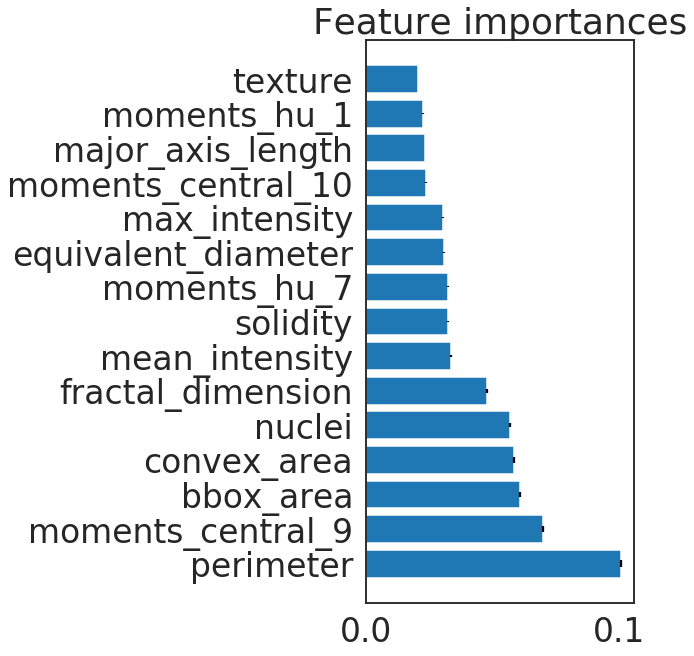

In [26]:
sns.set_context('talk', font_scale=2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Feature importances')
ax.barh(list(features[1:][indices])[:15],list(importances[indices])[:15], 
       yerr=list(std[indices])[:15], align="center")
#ax.set_xticks(range(X.shape[1]), indices)

fig.tight_layout()
fig.savefig('presentation_images/rf_feature_importances.pdf')